In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from src.data import get_blue_chip_returns
from src.objectives import compute_flat_moments, compute_z_alpha

n_assets = 50

tickers, returns = get_blue_chip_returns(start_date="2007-01-01", end_date="2009-12-31", n_assets=n_assets)
print("Tickers(total " + str(len(tickers)) + "):", tickers)

# moments
m1_flat, m2_flat, m3_flat, m4_flat = compute_flat_moments(returns)

# z alpha
z_alpha = compute_z_alpha(0.99)

Fetching data from 2007-01-01 to 2009-12-31...


[*********************100%***********************]  50 of 50 completed

2 Failed downloads:
['ABBV', 'NOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 00:00:00 -> 2009-12-31 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1262235600")')


Final asset count: 45
Tickers(total 45): ['AAPL', 'ADBE', 'AMD', 'AMZN', 'BA', 'BAC', 'BLK', 'BRK-B', 'CAT', 'CMCSA', 'COST', 'CRM', 'CSCO', 'CVX', 'DE', 'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'LOW', 'MA', 'MCD', 'MMM', 'MS', 'MSFT', 'NFLX', 'ORCL', 'PEP', 'PFE', 'PG', 'RTX', 'SPGI', 'TMO', 'TXN', 'UPS', 'WFC', 'WMT', 'XOM']


In [ ]:
from src.fire import FireOptimizer
from src.objectives import compute_modified_VaR
from tqdm import tqdm


optimizer = FireOptimizer(returns, verbose=False, long_only=True, f_tol=1e-8, c_tol=1e-8)

# optimize 100 times to benchmark
mVaR_values = []
portfolio_weights = []
for _ in tqdm(range(30), desc="FIRE optimization runs"):
    optimal_weights = optimizer.optimize(confidence=0.99)
    portfolio_weights.append(optimal_weights)
    mVaR = compute_modified_VaR(optimal_weights, m1_flat, m2_flat, m3_flat, m4_flat, z_alpha)
    mVaR_values.append(mVaR) 

FIRE optimization runs:  83%|████████▎ | 25/30 [06:21<01:16, 15.26s/it]


SystemError: CPUDispatcher(<function fire2 at 0x7f1d542e2660>) returned a result with an exception set

In [ ]:
from scipy.optimize import minimize, Bounds, BFGS
from src.objectives import compute_modified_VaR_gradient
import numpy as np

# sum of weights must equal 1
cons = ({'type': 'eq', 
         'fun': lambda w: np.sum(w) - 1.0, 
         'jac': lambda w: np.ones_like(w)})

# 0 <= w_i <= 1 (Long-only)
bounds = Bounds(0, 1)

def objective(w, m1, m2, m3, m4, z):
    return compute_modified_VaR(w, m1, m2, m3, m4, z)

def gradient(w, m1, m2, m3, m4, z):
    return compute_modified_VaR_gradient(w, m1, m2, m3, m4, z)

mVaR_values_slsqp = []
portfolio_weights_slsqp = []

w0_samples = []
for _ in range(30):
    # exponential distribution ensures a uniform distribution over the simplex
    w0 = np.random.exponential(1.0, size=m1_flat.shape[0])
    w0 /= np.sum(w0)
    w0_samples.append(w0)

for w0 in tqdm(w0_samples, desc="SLSQP optimization runs"):
    # --- SLSQP ---
    res_slsqp = minimize(
        fun=objective, 
        x0=w0, 
        args=(m1_flat, m2_flat, m3_flat, m4_flat, z_alpha),
        method='SLSQP', 
        jac=gradient, 
        bounds=bounds, 
        constraints=cons,
        tol=1e-8
    )
    mVaR_values_slsqp.append(res_slsqp.fun if res_slsqp.success else np.nan)
    portfolio_weights_slsqp.append(res_slsqp.x if res_slsqp.success else np.nan)

mVaR_values_trust = []
portfolio_weights_trust = []

for w0 in tqdm(w0_samples, desc="trust-constr optimization runs"):
    # --- trust-constr ---
    res_trust = minimize(
        fun=objective, 
        x0=w0, 
        args=(m1_flat, m2_flat, m3_flat, m4_flat, z_alpha),
        method='trust-constr', 
        hess=BFGS(),
        jac=gradient, 
        bounds=bounds, 
        constraints=cons,
        tol=1e-8,
        options={
        'gtol': 1e-8, 
        'xtol': 1e-8, 
        'barrier_tol': 1e-8,
        'maxiter': 10000,
        'verbose': 0
        }
    )
    print(res_trust.fun, res_trust.success)
    mVaR_values_trust.append(res_trust.fun if res_trust.success else np.nan)
    portfolio_weights_trust.append(res_trust.x if res_trust.success else np.nan)

SciPy SLSQP optimization runs:  88%|████████▊ | 88/100 [00:34<00:04,  2.52it/s]


KeyboardInterrupt: 

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_205762/3381268155.py:43: SyntaxWarning: invalid escape sequence '\m'
  stats_text = f"$\mu$: {mu:.6f}\n$\sigma$: {sigma:.2e}"
/tmp/ipykernel_205762/3381268155.py:43: SyntaxWarning: invalid escape sequence '\s'
  stats_text = f"$\mu$: {mu:.6f}\n$\sigma$: {sigma:.2e}"
/tmp/ipykernel_205762/3381268155.py:49: SyntaxWarning: invalid escape sequence '\m'
  stats_text = "$\mu$: nan\n$\sigma$: nan"


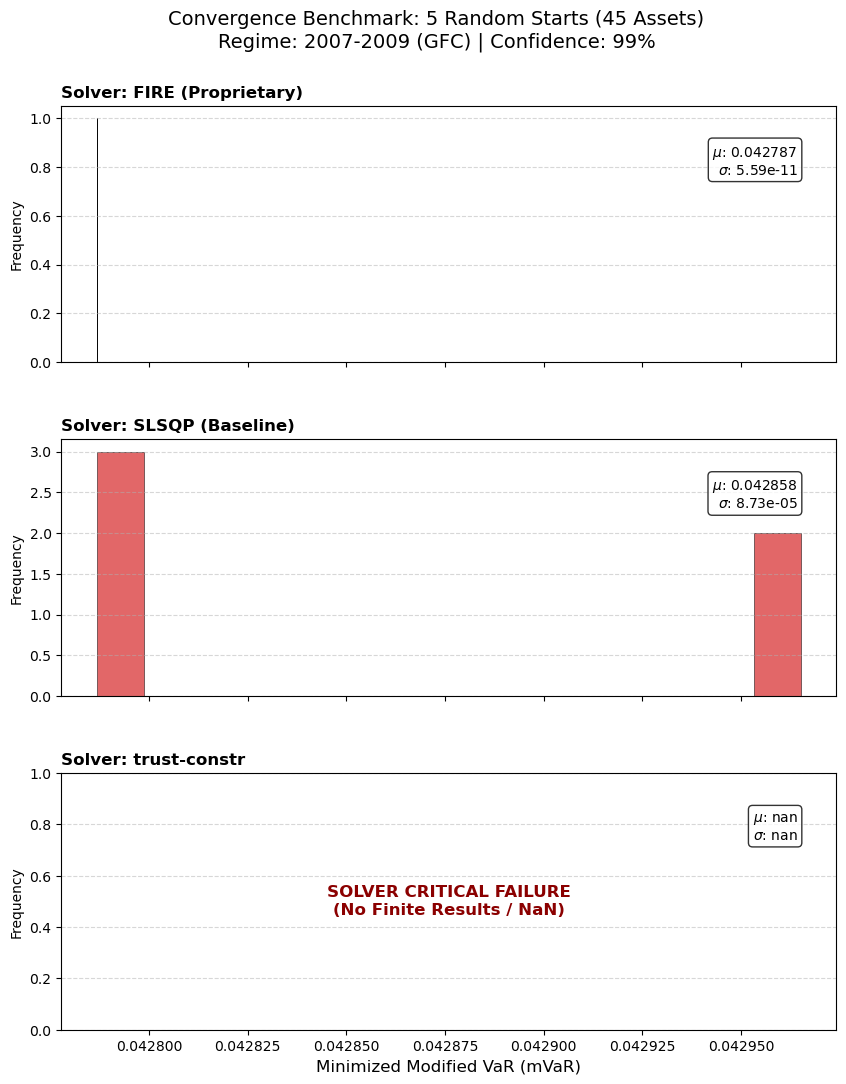

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
fire_vals = np.array(mVaR_values)
slsqp_vals = np.array(results['SLSQP'])
trust_vals = np.array(results['trust-constr'])

# clean nans
fire_clean = fire_vals[np.isfinite(fire_vals)]
slsqp_clean = slsqp_vals[np.isfinite(slsqp_vals)]
trust_clean = trust_vals[np.isfinite(trust_vals)]

data_sets = [fire_clean, slsqp_clean, trust_clean]
colors = ['#1f77b4', '#d62728', '#2ca02c']
labels = ['FIRE', 'SLSQP', 'trust-constr']

valid_data = [d for d in data_sets if d.size > 0]

if valid_data:
    all_data = np.concatenate(valid_data)
    x_min, x_max = np.min(all_data), np.max(all_data)
    # 5% padding
    margin = (x_max - x_min) * 0.05 if x_max != x_min else 0.001
    x_min -= margin
    x_max += margin
else:
    x_min, x_max = 0, 1

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.subplots_adjust(hspace=0.3)

for i, ax in enumerate(axes):
    current_data = data_sets[i]
    
    if current_data.size > 0:
        ax.hist(current_data, bins=15, color=colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)
        mu = np.mean(current_data)
        sigma = np.std(current_data)
        stats_text = f"$\mu$: {mu:.6f}\n$\sigma$: {sigma:.2e}"
    else:
        # failure case
        ax.text(0.5, 0.5, "SOLVER CRITICAL FAILURE\n(No Finite Results / NaN)", 
                transform=ax.transAxes, ha='center', va='center', 
                color='darkred', fontweight='bold', fontsize=12)
        stats_text = "$\mu$: nan\n$\sigma$: nan"

    ax.set_title(f'Solver: {labels[i]}', loc='left', fontweight='bold', fontsize=12)
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # stats box
    ax.text(0.95, 0.85, stats_text, transform=ax.transAxes, verticalalignment='top', 
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# global formatting
axes[-1].set_xlabel('Minimized Modified VaR (mVaR)', fontsize=12)
if valid_data:
    axes[-1].set_xlim(x_min, x_max)

plt.suptitle(f'Convergence Benchmark: {len(fire_vals)} Random Starts ({len(tickers)} Assets)\nRegime: 2007-2009 (GFC) | Confidence: 99%', 
             fontsize=14, y=0.96)

# final save
plt.savefig('optimization_benchmark_45_assets.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd

# 1. Identify the "Global Floor" portfolio across all successful runs
all_mvar = np.concatenate([fire_clean, slsqp_clean, trust_clean])
global_min_val = np.min(all_mvar)

# Find which weight vector produced this minimum
# We check FIRE first as it's the most likely candidate
if np.any(np.isclose(fire_vals, global_min_val, atol=1e-9)):
    best_weights = portfolio_weights[np.argmin(fire_vals)]
elif np.any(np.isclose(slsqp_vals, global_min_val, atol=1e-9)):
    best_weights = portfolio_weights_slsqp[np.argmin(slsqp_vals)]
else:
    best_weights = portfolio_weights_trust[np.nanargmin(trust_vals)]

def calculate_distances(weight_list, reference):
    distances = []
    for w in weight_list:
        if isinstance(w, np.ndarray) and np.all(np.isfinite(w)):
            # L2 Distance (Euclidean)
            dist = np.linalg.norm(w - reference)
            distances.append(dist)
        else:
            distances.append(np.nan)
    return np.array(distances)

# 2. Calculate distances from the global floor
dist_fire = calculate_distances(portfolio_weights, best_weights)
dist_slsqp = calculate_distances(portfolio_weights_slsqp, best_weights)
dist_trust = calculate_distances(portfolio_weights_trust, best_weights)

# 3. Print structural stability report
print(f"{'Solver':<15} | {'Mean L2 Dist':<15} | {'Max L2 Dist':<15} | {'Stability'}")
print("-" * 65)
for name, d in zip(['FIRE', 'SLSQP', 'trust-constr'], [dist_fire, dist_slsqp, dist_trust]):
    clean_d = d[np.isfinite(d)]
    if clean_d.size > 0:
        mu_d, max_d = np.mean(clean_d), np.max(clean_d)
        # Stability is the inverse of variance in weights
        status = "ROCK SOLID" if max_d < 1e-6 else "STRUCTURAL DRIFT"
        print(f"{name:<15} | {mu_d:<15.2e} | {max_d:<15.2e} | {status}")
    else:
        print(f"{name:<15} | {'N/A':<15} | {'N/A':<15} | FAILED")

# 4. Visualization of Portfolio Spread
plt.figure(figsize=(10, 6))
plt.boxplot([dist_fire[np.isfinite(dist_fire)], 
             dist_slsqp[np.isfinite(dist_slsqp)], 
             dist_trust[np.isfinite(dist_trust)]], 
            labels=['FIRE', 'SLSQP', 'trust-constr'])
plt.ylabel('L2 Distance from Global Minimum Portfolio')
plt.title('Portfolio Weight Stability (Structural Determinism)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()